# Bin Buddies 

### COSC 325 Introduction to Machine Learning
#### Group 15
#### Mia Patrikios, Yves Song, Hezekiah McDonald, Isaiah Weaver, Nia Maheshwari
---

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

# processing images with tensorflow 
# run 'pip install tensorflow' if module not found


from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

### One-Hot-Encoding Data

* new columns for the first five labels
* 0 or 1 values to indicate what category a sample belongs to

In [22]:
train_data = pd.read_csv("data/metadata.csv")
test_data = pd.read_csv("data/metadata.csv")

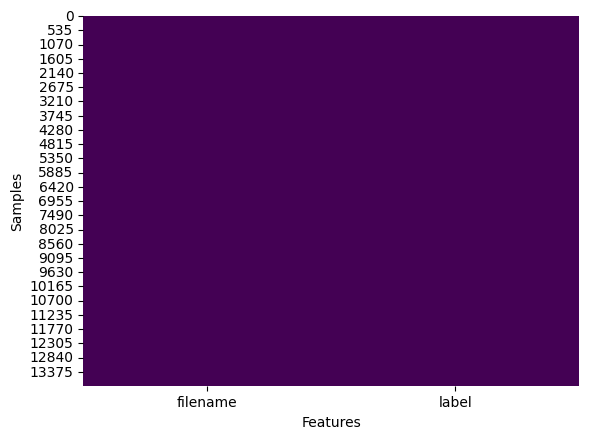

In [23]:
# checking for missing data in samples

sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

In [24]:
# one-hot-encoding data (all but last col) 

train_data['cardboard'] = train_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
train_data['glass'] = train_data['label'].apply(lambda x: 1 if x=='glass' else 0)
train_data['plastic'] = train_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
train_data['metal'] = train_data['label'].apply(lambda x: 1 if x=='metal' else 0)
train_data['paper'] = train_data['label'].apply(lambda x: 1 if x=='paper' else 0)
train_data = train_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


In [25]:
# one-hot-encoding data (all but last col) 

test_data['cardboard'] = test_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
test_data['glass'] = test_data['label'].apply(lambda x: 1 if x=='glass' else 0)
test_data['plastic'] = test_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
test_data['metal'] = test_data['label'].apply(lambda x: 1 if x=='metal' else 0)
test_data['paper'] = test_data['label'].apply(lambda x: 1 if x=='paper' else 0)
test_data = test_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


### Data Preprocessing Pipeline


In [26]:
# Mia 
!pip install scikit-image
import os
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import local_binary_pattern
from skimage.measure import moments_hu
##path = "cleaned/garbage-dataset-rgb"
path = "/Users/mp/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5"

def extract_features(img):
    
    # Ensure image is a NumPy array (shape: H × W × 3)
    if isinstance(img, Image.Image):
        img = np.array(img)
        
    # Colors (hsv histogram)
    
    # hsv (hue, saturation, value), the histogram creates a 3D histogram with 8 bins for each section
    hsv = rgb2hsv(img)  
    # create a 3D histogram with 8 bins for each channel
    hist, _ = np.histogramdd(
        hsv.reshape(-1, 3),
        bins=(8, 8, 8),
        range=((0, 1), (0, 1), (0, 1))
    )
    # flatten the histogram to a 512-length vector and normalize it
    color_features = hist.flatten() / (hist.sum() + 1e-6)
    
    # Textures (local binary pattern)
    
    # color is not relevant for texture, so convert to grayscale
    gray = rgb2gray(img)
    # lbp is a texture descriptor that compares each pixel to its neighbors
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    # create a histogram of the lbp values and normalize it
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 60), range=(0, 59))
    lbp_features = lbp_hist / (lbp_hist.sum() + 1e-6)
    
    # Shapes (hu moments)
    
    # convert gray images to 8-bit range for shape features
    gray_255 = (gray * 255).astype(np.uint8)
    # hu moments are shape descriptors that are not affected by scale, rotation, or translation
    hu = moments_hu(gray_255)
    # apply log transform to hu moments to reduce large ranges of numbers
    shape_features = np.log10(np.abs(hu) + 1e-6)
    
    # combine features into a single vector
    return np.concatenate([color_features, lbp_features, shape_features])

features_data = []

# loop thorugh all cleaned images in the dataset
for root, _, files in os.walk(path):
    label = os.path.basename(root)  # target names 
    for file in files:
        print(f"Processing {file}...")
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")
                features = extract_features(img)
                features_data.append([file_path, label] + features.tolist())
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# save to csv file
columns = ["file_path", "label"] + [f"f{i}" for i in range(len(features_data[0]) - 2)]
df = pd.DataFrame(features_data, columns=columns)
df.to_csv("features.csv", index=False)
    

Processing metadata.csv...
Error processing /Users/mp/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5/Garbage_Dataset_Classification/metadata.csv: cannot identify image file '/Users/mp/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5/Garbage_Dataset_Classification/metadata.csv'
Processing paper_02933.jpg...
Processing paper_01584.jpg...
Processing paper_00842.jpg...
Processing paper_02099.jpg...
Processing paper_01590.jpg...
Processing paper_00856.jpg...
Processing paper_02927.jpg...
Processing paper_02714.jpg...
Processing paper_00665.jpg...
Processing paper_02072.jpg...
Processing paper_02066.jpg...
Processing paper_00117.jpg...
Processing paper_02700.jpg...
Processing paper_01221.jpg...
Processing paper_02728.jpg...
Processing paper_00659.jpg...


/Users/mp/ML-TEAM-15/.venv/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processing paper_00895.jpg...
Processing paper_01235.jpg...
Processing paper_01962.jpg...
Processing paper_01976.jpg...
Processing paper_03191.jpg...
Processing paper_01792.jpg...
Processing paper_03185.jpg...
Processing paper_02270.jpg...
Processing paper_02516.jpg...
Processing paper_02502.jpg...
Processing paper_00473.jpg...
Processing paper_02264.jpg...
Processing paper_01745.jpg...
Processing paper_03152.jpg...
Processing paper_01037.jpg...
Processing paper_00329.jpg...
Processing paper_02258.jpg...
Processing paper_01989.jpg...
Processing paper_01816.jpg...
Processing paper_01802.jpg...
Processing paper_02489.jpg...
Processing paper_02304.jpg...
Processing paper_00513.jpg...
Processing paper_02462.jpg...
Processing paper_02476.jpg...
Processing paper_00261.jpg...
Processing paper_00507.jpg...
Processing paper_02310.jpg...
Processing paper_01631.jpg...
Processing paper_03026.jpg...
Processing paper_02338.jpg...
Processing paper_00249.jpg...
Processing paper_01157.jpg...
Processing

* Resize images to make them all have the same shape (e.g., 128x128x3 or 224x224x3).
* Normalize pixel values by scaling pixel intensities (from [0,255] to [0,1] or [-1,1], for example)
* Data augmentation (optional) such as random rotations, flips, zooms, brightness shifts to improve generalization.
* batching samples by converting dataset into batches for training

### Normalize Data & Remove Colinear Features  - Isaiah Weaver

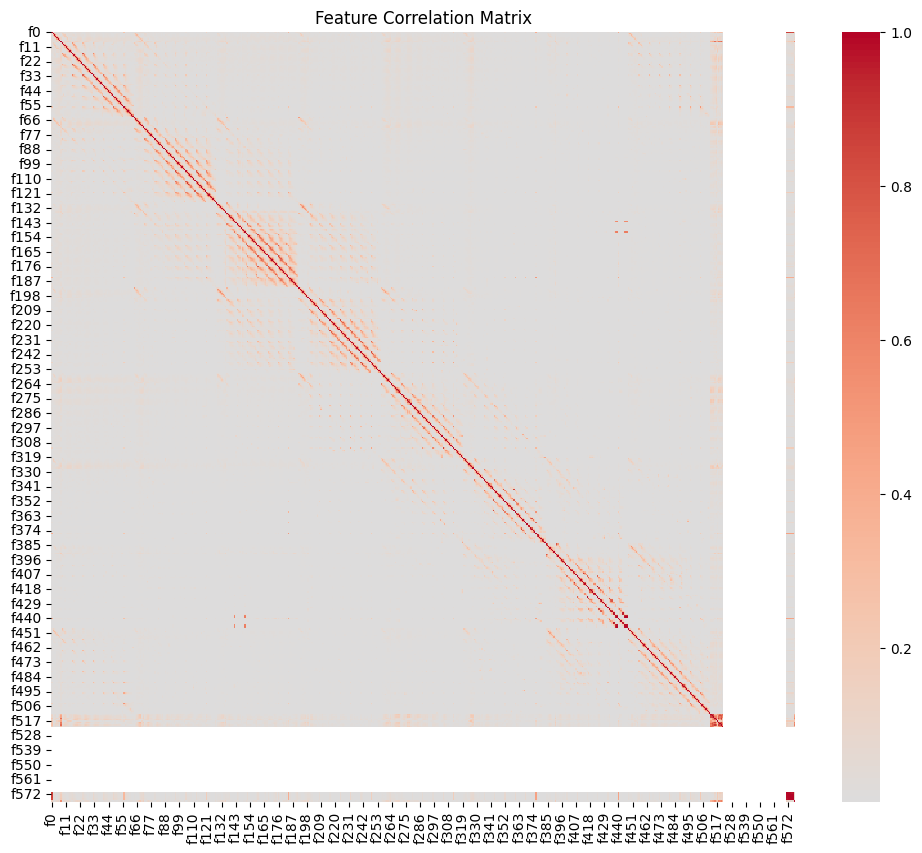

Dropping 14 highly collinear features: ['f422', 'f424', 'f437', 'f439', 'f443', 'f444', 'f445', 'f446', 'f447', 'f572', 'f573', 'f574', 'f575', 'f576']


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("features.csv")

# Separate features and labels
feature_cols = [c for c in df.columns if c not in ["file_path", "label"]]
X = df[feature_cols]
y = df["label"]
file_paths = df["file_path"]

# Normalize features between 1 and 0
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Compute correlation matrix
corr_matrix = X_scaled.corr().abs()

# Visualize 
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify and drop highly collinear features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(f"Dropping {len(to_drop)} highly collinear features:", to_drop)

X_reduced = X_scaled.drop(columns=to_drop)

# re-Combine with labels and file paths
df_clean = pd.concat([file_paths, y, X_reduced], axis=1)

# Save cleaned CSV
df_clean.to_csv("features_clean.csv", index=False)
print(f"Final dataset has {X_reduced.shape[1]} features (down from {len(feature_cols)})")


In [28]:
def load_image(path):

IndentationError: expected an indented block (2045661557.py, line 1)

In [ ]:
def resize_image(img):

In [ ]:
def normalize_image(img):

In [ ]:
def preprocess(path, label):